In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import copy
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, PyMol
from rdkit.Chem import Draw
import MDAnalysis as mda
import prolif
from tqdm.auto import tqdm
import seaborn as sns

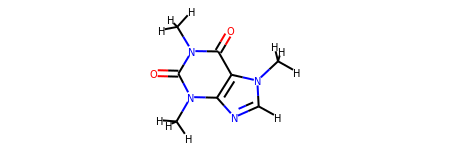

In [2]:
u = mda.Universe.from_smiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C", numConfs=5)
mol = u.atoms.convert_to("RDKIT")
mol

<prolif.molecule.Molecule with 1 residues and 24 atoms at 0x7f36e73a6b70>


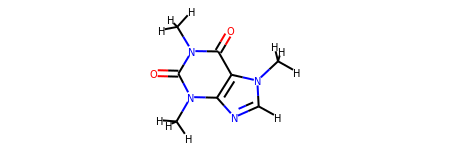

In [3]:
m = prolif.Molecule(mol)
print(repr(m))
m

In [4]:
m.residues

<prolif.residue.ResidueGroup with 1 residues at 0x7f36e7397940>

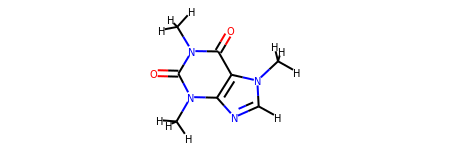

In [5]:
next(iter(m))

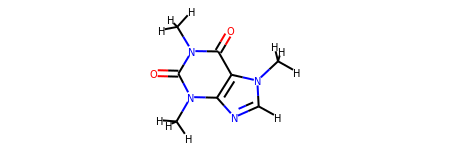

In [6]:
m["UNK1"]

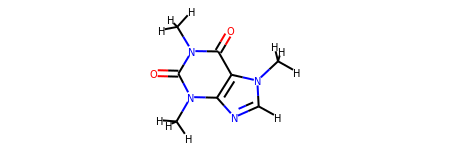

In [7]:
m[0]

# Trajectory

In [5]:
# load traj
u = mda.Universe(prolif.datafiles.TOP, prolif.datafiles.TRAJ)
ag = u.atoms
ag

<AtomGroup with 5067 atoms>

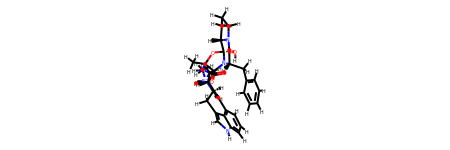

In [6]:
lig = ag.select_atoms("resname ERM")
prot = ag.select_atoms("protein")
prot_mol = prolif.Molecule(prot.convert_to("RDKIT"))
lig.convert_to("RDKIT")

In [7]:
fp = prolif.Fingerprint().run(u.trajectory, lig, prot, residues="pocket")
fp

<prolif.fingerprint.Fingerprint: 8 interactions: ['Hydrophobic', 'HBDonor', 'HBAcceptor', 'PiStacking', 'Anionic', 'Cationic', 'CationPi', 'PiCation'] at 0x7efc02351f40>

In [8]:
df = fp.to_dataframe()
df

Frame     TYR38.0    TYR109.0    THR110.0    TRP125.0    LEU126.0  \
         Hydrophobic Hydrophobic Hydrophobic Hydrophobic Hydrophobic   
0      0           0           1           0           0           1   
1      1           1           0           0           0           1   
2      2           0           0           0           0           1   
3      3           0           1           0           0           1   
4      4           0           1           1           1           1   
5      5           0           1           0           0           1   
6      6           0           1           1           1           1   
7      7           0           1           0           1           1   
8      8           0           1           1           0           1   
9      9           0           1           1           1           1   
10    10           0           0           0           0           0   
11    11           0           1           0           1           1   
12    12           0           1           1           0           1   
13    13           0           1           0           0           1   
14    14           1           0           0           0           1   
15    15           1           1           0           0           1   
16    16           1           0           0           0           1   
17    17           1           0           0           0           1   
18    18           0           1           0           0           1   
19    19           1           1           0           0           1   
20    20           1           1           0           0           1   
21    21           0           1           0           1           1   
22    22           0           1           0           1           0   
23    23           0           1           0           1           1   
24    24           0           1           0           1           1   

      ASP129.0                     ILE130.0  ...   PHE331.1    SER334.1  \
   Hydrophobic HBDonor Cationic Hydrophobic  ... PiStacking Hydrophobic   
0            1       1        1           1  ...          1           1   
1            1       1        1           1  ...          1           0   
2            1       1        1           1  ...          0           1   
3            1       1        1           1  ...          0           0   
4            1       1        1           1  ...          0           0   
5            1       1        1           1  ...          1           0   
6            1       1        1           1  ...          0           0   
7            1       1        1           1  ...          1           0   
8            1       0        1           1  ...          0           0   
9            1       1        1           1  ...          0           0   
10           1       1        1           1  ...          0           0   
11           1       1        1           1  ...          0           0   
12           1       1        1           1  ...          0           0   
13           1       1        1           1  ...          0           0   
14           1       1        1           1  ...          0           1   
15           1       1        1           1  ...          0           1   
16           1       1        1           1  ...          0           1   
17           0       0        0           1  ...          0           1   
18           1       1        1           1  ...          0           1   
19           1       1        1           1  ...          0           1   
20           1       1        1           1  ...          0           1   
21           1       1        1           1  ...          0           1   
22           1       1        1           1  ...          0           1   
23           1       1        1           1  ...          0           1   
24           1       1        1           1  ...          0           1   

      MET337.1    TRP345.1    PH

In [10]:
resid = prolif.ResidueId("ALA")
prot_mol[resid]

<prolif.residue.ResidueGroup with 27 residues at 0x7efc00e01460>

In [12]:
df.xs("PiStacking", level=1, axis=1)

,PHE330.1,PHE331.1
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0
5,0,1
6,0,0
7,1,1
8,0,0
9,0,0


In [13]:
df["ASP129.0"]

,Hydrophobic,HBDonor,Cationic
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
5,1,1,1
6,1,1,1
7,1,1,1
8,1,0,1
9,1,1,1


In [14]:
from rdkit import DataStructs
bv = fp.to_bitvectors()
DataStructs.TanimotoSimilarity(bv[0], bv[1])

0.8571428571428571

In [43]:
# prot-prot interactions
fp = prolif.Fingerprint(["Hydrophobic", "HBDonor", "HBAcceptor", 'PiStacking', 'Cationic'])
print(fp)
ifp = []

for ts in tqdm(u.trajectory):   
    prot_mol = prolif.Molecule(prot.convert_to("RDKIT"))
    tm3 = prot_mol[75:105]
    others = prot_mol[[i for i in range(prot_mol.n_residues) if i < 70 or i >= 115]]

    data = {"Frame": ts.frame}
    for lresid, ligres in tm3.items():
        for presid, pres in others.items():
            bs = fp.get(ligres, pres)
            if bs.sum() > 0:
                try:
                    previous = data[presid]
                except KeyError:
                    data[presid] = bs
                else:
                    data[presid] = previous | bs

    ifp.append(data)

ifp[0]

<prolif.encoder.Encoder: 5 interactions: ['Hydrophobic', 'HBDonor', 'HBAcceptor', 'PiStacking', 'Cationic'] at 0x7f4943b59490>


{'Frame': 0,
 CYS68.M: array([1, 1, 0, 0, 0], dtype=uint8),
 LEU165.M: array([1, 1, 0, 0, 0], dtype=uint8),
 ILE153.M: array([1, 0, 0, 0, 0], dtype=uint8),
 ILE166.M: array([1, 0, 0, 0, 0], dtype=uint8),
 CYX167.M: array([1, 0, 0, 0, 0], dtype=uint8),
 PHE146.M: array([1, 0, 0, 1, 0], dtype=uint8),
 PRO151.M: array([1, 0, 0, 0, 0], dtype=uint8),
 LEU69.M: array([1, 0, 0, 0, 0], dtype=uint8),
 ILE142.M: array([1, 0, 0, 0, 0], dtype=uint8),
 GLU149.M: array([0, 0, 0, 0, 1], dtype=uint8),
 THR169.M: array([0, 1, 0, 0, 0], dtype=uint8),
 GLY173.M: array([1, 0, 0, 0, 0], dtype=uint8),
 CYS65.M: array([1, 0, 0, 0, 0], dtype=uint8),
 LEU178.M: array([1, 0, 0, 0, 0], dtype=uint8),
 MET236.M: array([1, 0, 0, 0, 0], dtype=uint8),
 GLN138.M: array([1, 0, 0, 0, 0], dtype=uint8),
 PRO177.M: array([1, 0, 0, 0, 0], dtype=uint8),
 ASN181.M: array([1, 0, 1, 0, 0], dtype=uint8),
 ILE135.M: array([1, 0, 0, 0, 0], dtype=uint8),
 LEU139.M: array([1, 0, 0, 0, 0], dtype=uint8),
 GLY58.M: array([1, 0, 0, 0, 0

In [44]:
df = prolif.to_dataframe(ifp, fp)
df

Frame      ACE1.M      ILE2.M            SER46.M     SER47.M          \
         Hydrophobic Hydrophobic HBAcceptor HBDonor Hydrophobic HBDonor   
0      0           0           0          0       0           0       0   
1      5           0           0          0       0           0       0   
2     10           0           0          0       0           0       0   
3     15           0           0          0       0           0       0   
4     20           0           0          0       0           0       0   
5     25           1           0          0       0           1       0   
6     30           0           0          0       0           0       0   
7     35           0           0          0       0           0       0   
8     40           0           0          0       0           0       0   
9     45           0           0          0       1           0       1   
10    50           0           0          0       0           0       0   
11    55           0           0          0       0           0       0   
12    60           0           0          0       0           0       0   
13    65           1           1          0       0           0       0   
14    70           0           0          0       0           0       0   
15    75           1           1          1       1           1       0   
16    80           1           0          0       0           1       1   

       SER48.M             GLU50.M  ...    THR215.M            CYS216.M  \
   Hydrophobic HBDonor Hydrophobic  ... Hydrophobic HBDonor Hydrophobic   
0            1       1           0  ...           1       1           1   
1            0       1           0  ...           0       1           0   
2            0       0           0  ...           1       1           1   
3            1       1           0  ...           1       0           0   
4            1       0           0  ...           1       1           0   
5            0       0           0  ...           1       0           0   
6            1       1           0  ...           1       1           1   
7            1       1           1  ...           1       0           0   
8            0       0           0  ...           1       1           1   
9            0       0           0  ...           1       0           1   
10           1       0           0  ...           1       1           1   
11           0       1           0  ...           1       1           1   
12           0       0           0  ...           1       1           1   
13           1       0           0  ...           1       0           0   
14           0       0           0  ...           1       1           1   
15           1       1           0  ...           0       0           0   
16           1       1           0  ...           1       0           0   

      TRP219.M    PHE222.M    ILE233.M    MET236.M    CYS237.M    VAL240.M  \
   Hydrophobic Hydrophobic Hydrophobic Hydrophobic Hydrophobic Hydrophobic   
0            1           0           0           1           0           0   
1            0           0           0           1           0           1   
2            1           0           0           1           0           1   
3            0           0           0           1           0           1   
4            1           0           1           1           1           1   
5            0           0           1           1           1           1   
6            0           0           0           1           0           1   
7            1           0           0           1           1           1   
8            0           0           0           1           0           0   
9            0           0           0           1           0           1   
10           0           0           0           0           0           1   
11           0           0           0           1           0           1   
12           1           0           0           1         

In [45]:
bv = prolif.to_bitvectors(ifp, encoder)
DataStructs.BulkTanimotoSimilarity(bv[0], bv)

[1.0,
 0.5217391304347826,
 0.6176470588235294,
 0.5571428571428572,
 0.5394736842105263,
 0.5,
 0.5692307692307692,
 0.5131578947368421,
 0.5797101449275363,
 0.5217391304347826,
 0.578125,
 0.5441176470588235,
 0.5507246376811594,
 0.5285714285714286,
 0.5909090909090909,
 0.5066666666666667,
 0.5]

In [5]:
fp = prolif.Fingerprint(["XBDonor", "HBDonor", "HBAcceptor", "PiCation", 'FaceToFace', 'EdgeToFace'])
u.trajectory[25]
prot_mol = prolif.Molecule(prot.convert_to("RDKIT"))
lig_mol = prolif.Molecule(lig.convert_to("RDKIT"))
residues = prolif.get_pocket_residues(lig_mol, prot_mol)
ifp = {}
atoms = {}
for res in residues:
    bs, ids = fp.get_with_atoms(lig_mol[0], prot_mol[res])
    if bs.sum() > 0:
        ifp[res] = bs
        atoms[res] = [tup for tup in ids if tup != (None, None)]
atoms

{TYR93.M: [[None, None],
  [None, None],
  [7, 2414],
  [None, None],
  [None, None],
  [None, None]],
 TRP219.M: [[None, None],
  [None, None],
  [None, None],
  [None, None],
  [10, 767],
  [None, None]],
 PHE222.M: [[None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None],
  [10, 714]]}

In [ ]:
# For WSL2: portforward requests from localhost:9123 to windows-localhost:9123
# in windows firewall: Add rule to allow connections to port 9123 TCP
# in a powershell with admin rights:
# netsh interface portproxy add v4tov4 listenport=9123 listenaddress=0.0.0.0 connectport=9123 connectaddress=127.0.0.1
# in a wsl2 shell:
# socat -d -d TCP-LISTEN:9123,reuseaddr,fork TCP:$(cat /etc/resolv.conf | tail -n1 | cut -d " " -f 2):9123

In [22]:
colors = {
    "HBAcceptor": "red",
    "FaceToFace": "blue",
    "EdgeToFace": "orange",
}
s = PyMol.MolViewer()
s.DeleteAll()
s.ShowMol(lig_mol[0], name="ligand", showOnly=False, showSticks=True)
s.server.do("color cyan, ligand and elem C")
for res in ifp.keys():
    ids = [t for t in atoms[res] if t[0] is not None][0]
    for a1 in lig_mol[0].GetAtoms():
        if a1.GetUnsignedProp("mapindex") == ids[0]:
            break
    
    for a2 in prot_mol[res].GetAtoms():
        if a2.GetUnsignedProp("mapindex") == ids[1]:
            break
    resname = f"res{str(res)[:-2]}"
    s.ShowMol(prot_mol[res], name=resname, showOnly=False)
    s.server.do(f"color green, {resname} and elem C")
    s.server.do(f"distance lig-{resname}, ligand and id {a1.GetIdx()+1}, {resname} and id {a2.GetIdx()+1}")
    s.server.do(f"hide label, lig-{resname}")
    itype = list(fp.interactions.keys())[np.where(ifp[res] == True)[0][0]]
    color = colors[itype]
    s.server.do(f"color {color}, lig-{resname}")

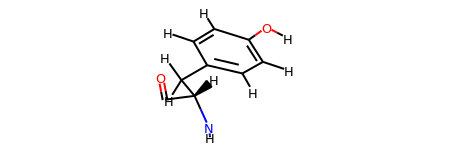

In [38]:
prot_mol["TYR93.M"]

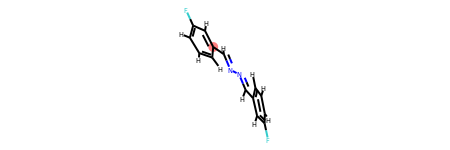

In [74]:
atom_idx = 10
mol = lig_mol

atom = mol.GetAtomWithIdx(atom_idx)
resid = prolif.ResidueId.from_atom(atom)
i = [a.GetIdx() for a in mol[resid].GetAtoms() if a.GetUnsignedProp("mapindex") == atom_idx][0]
mol[resid].__sssAtoms = [i]
mol[resid]

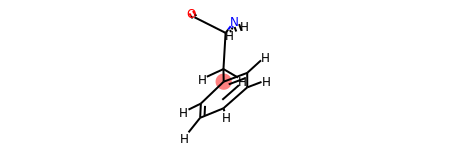

In [75]:
atom_idx = 714
mol = prot_mol

atom = mol.GetAtomWithIdx(atom_idx)
resid = prolif.ResidueId.from_atom(atom)
i = [a.GetIdx() for a in mol[resid].GetAtoms() if a.GetUnsignedProp("mapindex") == atom_idx][0]
mol[resid].__sssAtoms = [i]
mol[resid]

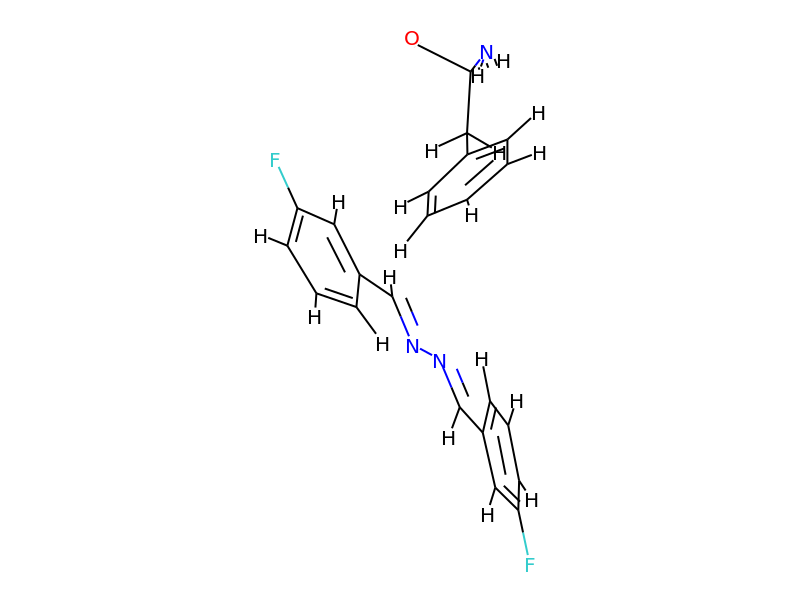

In [76]:
mol = AllChem.CombineMols(prot_mol["PHE222.M"], lig_mol[0])
Draw.MolToImage(mol, size=(800,600))

In [86]:
class CloseContact(prolif.Interaction):
    def __init__(self, distance=2.0):
        self.distance = distance
    def detect(self, res1, res2):
        for a1 in res1.GetAtoms():
            p1 = res1.xyz[a1.GetIdx()]
            for a2 in res2.GetAtoms():
                p2 = res2.xyz[a2.GetIdx()]
                dist = np.linalg.norm(p1 - p2)
                if dist <= self.distance:
                    return True

prolif.Fingerprint(["Hydrophobic", "CloseContact"]).get(lig_mol[0], prot_mol["PHE222.M"])

[True, None]

In [15]:
fp = prolif.Fingerprint("all").run(u.trajectory, lig, prot)
df = fp.to_dataframe()
df.shape

(25, 40)

Removed CYS344.1, PHE346.1, PRO338.1, TRP345.1 - Only a single interaction


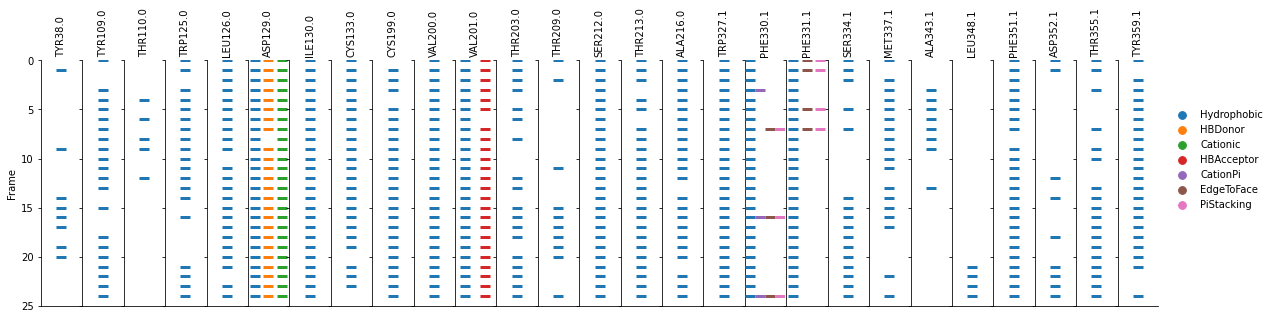

In [31]:
data = pd.melt(df, id_vars=["Frame"], var_name=["residue","interaction"])
data = data[data["value"] != 0]
data.reset_index(inplace=True, drop=True)
# remove residues appearing less than 1% of the time
t = data.groupby(["residue","interaction"], as_index=False).agg({"value":"count"}).groupby("residue", as_index=False).agg({"value":"max"})
todrop = t.loc[t["value"] <= 1].residue.tolist()
data = data[~data["residue"].isin(todrop)]
print("Removed", ", ".join(todrop), "- Only a single interaction")

# plot
sns.set_context(font_scale=1.3)
g = sns.catplot(
    data=data, x="interaction", y="Frame", hue="interaction", col="residue",
    height=4, aspect=0.15, jitter=0, sharex=False, marker="_", s=10, linewidth=3,
)
g.set_titles("{col_name}", rotation=90)
g.set(xticks=[], ylim=(0,data.Frame.max()+1))
g.set_xticklabels([])
g.set_xlabels("")
g.fig.subplots_adjust(wspace=.02)
g.add_legend()
for ax in g.axes.flat:
    ax.invert_yaxis()

In [ ]:
# old code

In [11]:
from math import pi
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.palettes import Category10
from bokeh.models import ColumnDataSource, FactorRange, HoverTool, Legend, FixedTicker

In [12]:
# interactive plot
output_notebook()

data_bokeh = data.drop(columns="value").copy()
interactions = data_bokeh.interaction.unique()
colors = Category10.get(len(interactions))
residues = data_bokeh.residue.unique()
x_range = [(residue, interaction) for residue in residues for interaction in interactions]

renderers = []
legend_items = []
p = figure(x_range=FactorRange(*x_range), plot_width=900, plot_height=1800)
for i, (interaction, color) in enumerate(zip(interactions, colors)):
    d = data_bokeh.loc[data_bokeh["interaction"]==interaction]
    x = [(r,i) for r in d.residue]
    y = d["Frame"]
    r = p.dash(
        x=x, y=y, color=color,
        line_width=2, size=5, alpha=0.7, hover_alpha=1.0,
    )
    #renderers.append(r)
    legend_items.append((interaction,[r]))

p.add_tools(HoverTool(
    tooltips=[("Frame","@y")], mode='hline',
    #tooltips=None, renderers=renderers, mode='hline'
))
p.y_range.start = -1
p.y_range.end = data_bokeh.Frame.max()+1

p.ygrid.visible = False
p.xgrid.grid_line_alpha = 0.5
p.xgrid.ticker = p.xaxis[0].ticker
p.xaxis.group_label_orientation = pi/2
p.xaxis.major_label_text_color = None

p.add_layout(Legend(items=legend_items, click_policy="hide"), 'right')

show(p)

Loading BokehJS ...